# EDA

The objective of this notebook is to perform an Exploratory Data Analysis on the `ice_cream_data` data set that I wrangled in my previous Data Wrangling notebook.

I believe that one of the best ways to perform EDA to start off with a set of basic questions I want answered:
* What are the best flavors from each brand?
* What are the worst flavors from each brand?
* Which words compose a good review?
* Which words compose a bad review?
* Is the data balanced?
* Are the flavors from each brand that are are being reviewd balanaced?

I realize that most of the questions I have posed are not NLP centric even though this is an NLP project. This is because I think insights on other parts of the data could be important to how I address the NLP problem. At the very least, I learn more about the dataset.

I'll start by loading some libraries that will help me answer these questions and create some visualizations.

In [17]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import scattertext as st
from textblob import TextBlob
import matplotlib.pyplot as plt
from wordcloud import WordCloud
warnings.filterwarnings("ignore")

Next, I'll load the data.

In [7]:
data = pd.read_csv('../data/ice_cream_data.csv', index_col=0)

In [8]:
data.head(3)

,author,brand,name,rating,rating_count,stars,text,good_review
0,Ilovebennjerry,bj,Salted Caramel Core,3.7,208,3,not enough brownie super good dont get wrong b...,Bad
1,Sweettooth909,bj,Salted Caramel Core,3.7,208,5,im obsessed pint i decided try although im hug...,Good
2,LaTanga71,bj,Salted Caramel Core,3.7,208,3,my favoritemore caramel please my caramel core...,Bad


In [9]:
brands = list(data['brand'].value_counts().index)
print(brands)

['bj', 'breyers', 'hd', 'talenti']


In [10]:
brand_labels = ['Ben and Jerry\'s', 'Breyers',  'Haagen Daz', 'Talenti']

## Number of Reviews

It is important to know the overall balance of the dataset. Let's see how many good/bad reviews we are working with.

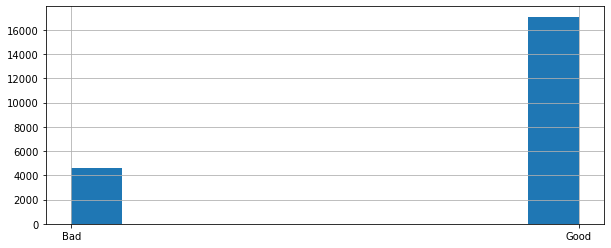

In [11]:
plt.figure(figsize=(10,4))
data['good_review'].hist()
plt.show()

In [12]:
print(data['good_review'].value_counts())
print("\nGood Percentage: ", data['good_review'].value_counts()[0]/len(data['good_review']) * 100,
      "\nBad Percentage: ", data['good_review'].value_counts()[1]/len(data['good_review']) * 100)

Good    17079
Bad      4595
Name: good_review, dtype: int64

Good Percentage:  78.79948325182245 
Bad Percentage:  21.200516748177538


The data clearly favors the good reviews. Depending on the rest of the EDA, I may consider upsampling during preprocessing.

So now that I know there are more good reviews than bad ones, I can look to see if there is internal balance in the data. One way to check for this is to see the number of reviews by brand.

In [13]:
num_of_reviews = np.array([len(data[data['brand'] == brand]) for brand in brands])
total_reviews = sum(num_of_reviews)
num_of_reviews_percentage = num_of_reviews/total_reviews

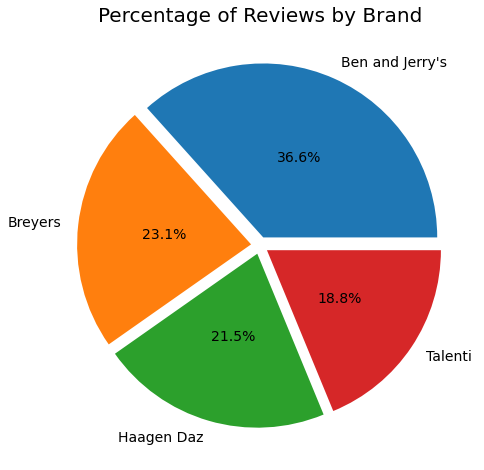

In [14]:
plt.figure(figsize=(8,8))
plt.pie(x=num_of_reviews_percentage, autopct="%.1f%%", explode=[0.05]*4, 
        labels=brand_labels, 
        pctdistance=0.5, textprops={'fontsize': 14})
plt.title('Percentage of Reviews by Brand', fontsize=20)
plt.show()

The largest majority comes from Ben & Jerry's, but the data is not *super* imbalanced in terms of brand, so that's good.

Where I expect there might be much more imbalance is when I dive deeper to see the proportion of reviews by flavor.

In [15]:
flavor_counts_percentage = []
flavor_names = []
for brand in brands:
    flavor_counts = np.array(data[data['brand'] == brand]['name'].value_counts())
    flavor_names.append(data[data['brand'] == brand]['name'].value_counts().index.tolist())
    flavor_counts_percentage.append(flavor_counts/sum(flavor_counts))
flavor_counts_percentage_greater_2 = []
flavor_percentage_greater_2_names = []
for i in range(len(flavor_counts_percentage)):
    arr = []
    names = []
    for j in range(len(flavor_counts_percentage[i])):
        # check if flavor makes up more than 2 percent of the total flavors of that brand
        if flavor_counts_percentage[i][j] >= 0.02:
            arr.append(flavor_counts_percentage[i][j])
            names.append(flavor_names[i][j])
    arr.append(1-sum(arr))
    flavor_counts_percentage_greater_2.append(arr)
    names.append(str(len(flavor_names[i])-len(names)) + ' Other Flavors Each Composing of Less Than 2%')
    flavor_percentage_greater_2_names.append(names)

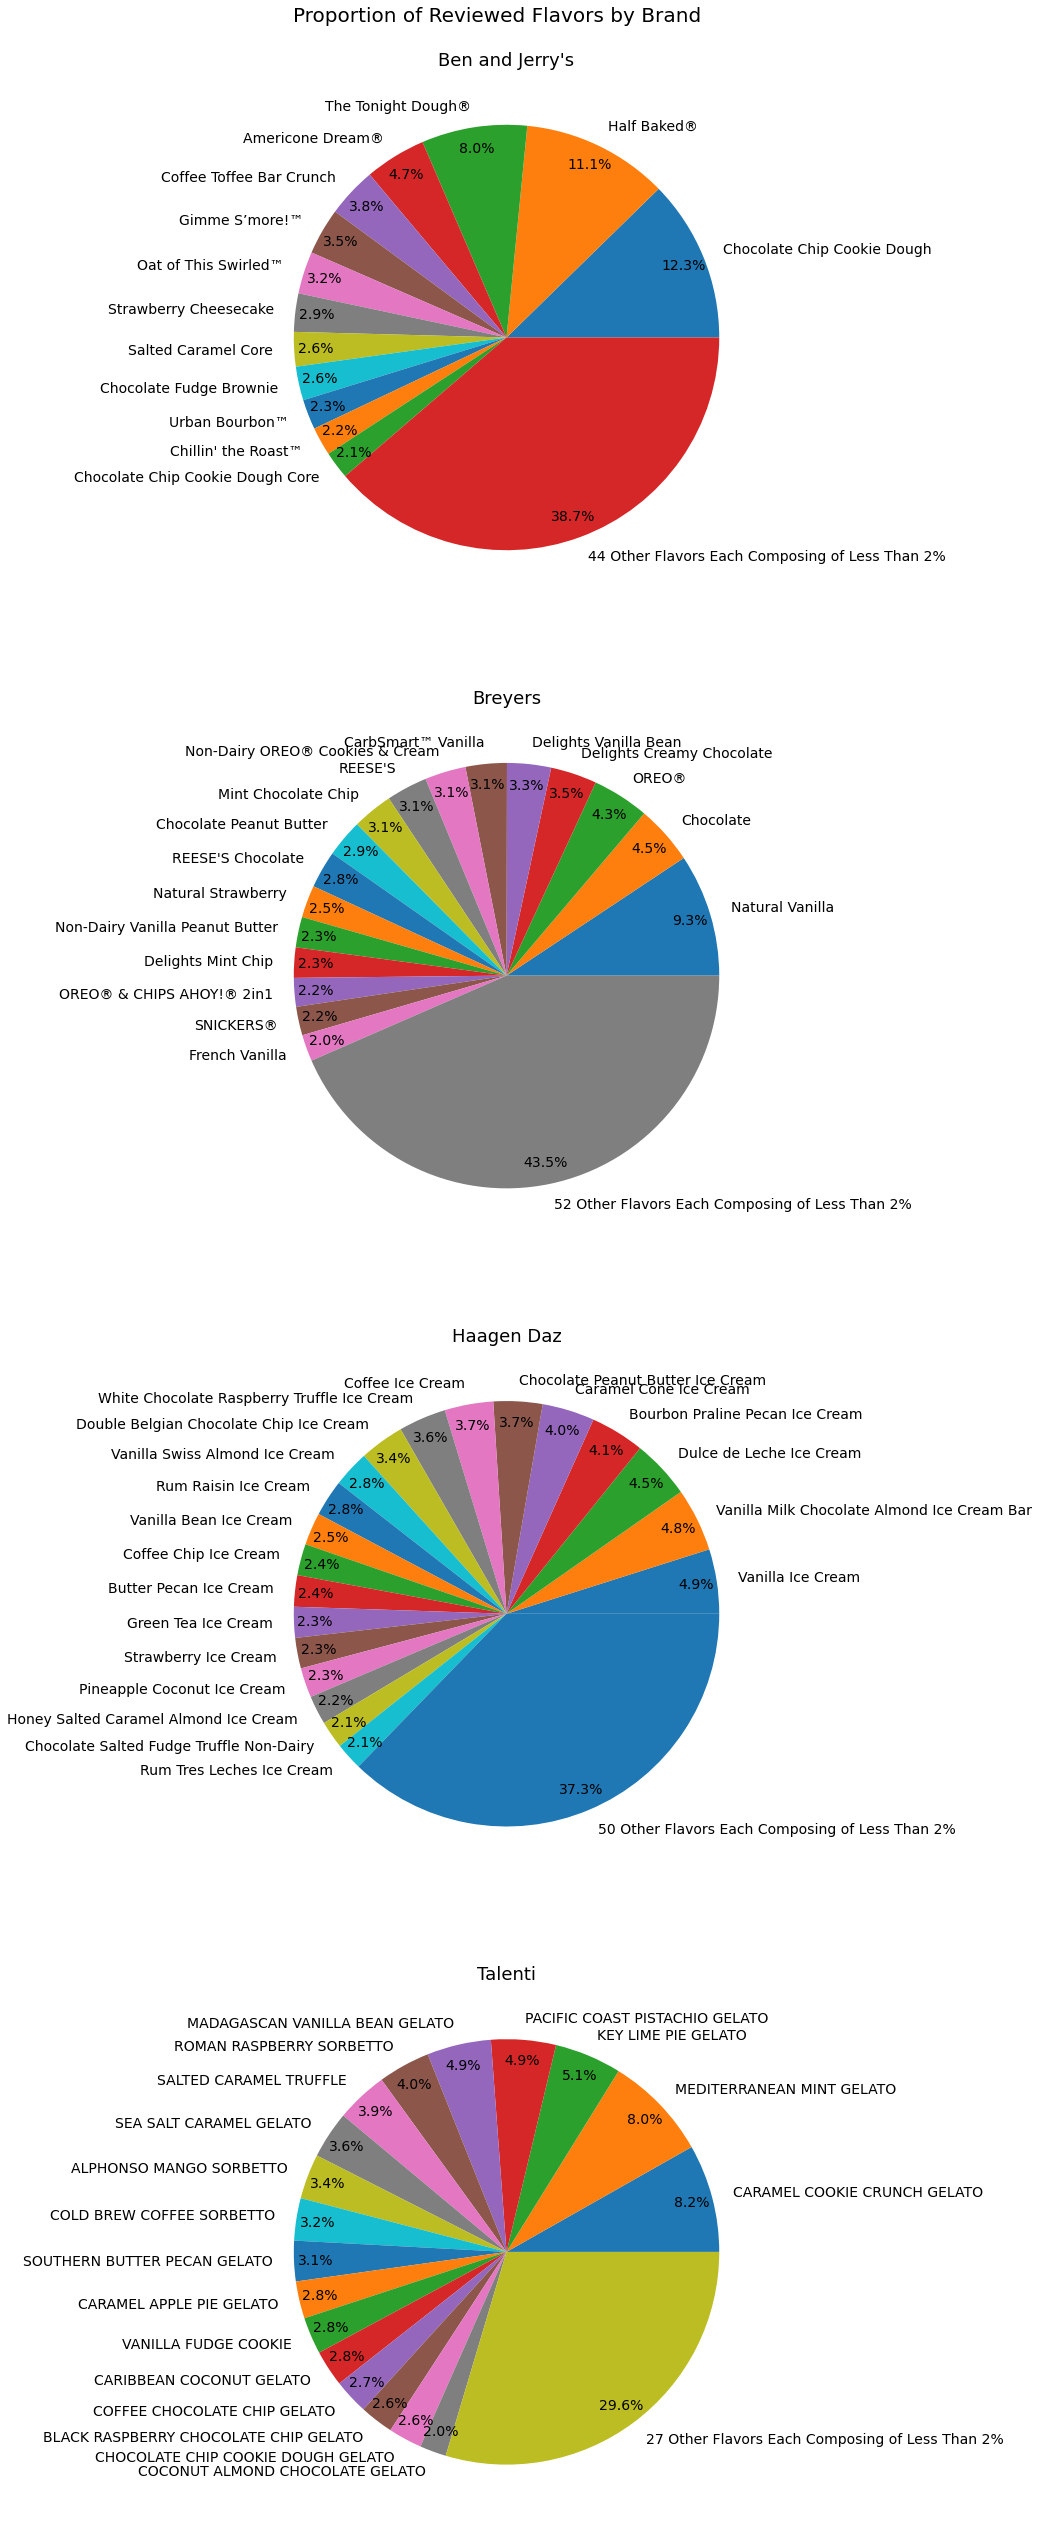

In [18]:
fig, axes = plt.subplots(4, 1, figsize=(10,45))
fig.suptitle('Proportion of Reviewed Flavors by Brand', fontsize=20, y=0.9)
axes[0].pie(x=flavor_counts_percentage_greater_2[0], autopct="%.1f%%", labels=flavor_percentage_greater_2_names[0], 
            pctdistance=0.9, textprops={'fontsize': 14})
axes[0].set_title(brand_labels[0], fontsize=18)

axes[1].pie(x=flavor_counts_percentage_greater_2[1], autopct="%.1f%%", labels=flavor_percentage_greater_2_names[1], 
            pctdistance=0.9, textprops={'fontsize': 14})
axes[1].set_title(brand_labels[1], fontsize=18)
axes[2].pie(x=flavor_counts_percentage_greater_2[2], autopct="%.1f%%", labels=flavor_percentage_greater_2_names[2], 
            pctdistance=0.9, textprops={'fontsize': 14})
axes[2].set_title(brand_labels[2], fontsize=18)
axes[3].pie(x=flavor_counts_percentage_greater_2[3], autopct="%.1f%%", labels=flavor_percentage_greater_2_names[3], 
            pctdistance=0.9, textprops={'fontsize': 14})
axes[3].set_title(brand_labels[3], fontsize=18)
plt.show()

There are clearly some flavors that are more reviewed that others. However, no flavor from any brand has a overly dominating share of the total reviews. This confirms that the data is pretty balanced overall.

## Top 5 Best and Worst Flavors From Each Brand

In [19]:
# find top and bottom 5 flavors in each brand with their avg rating
top5_flavors = {}
bottom5_flavors = {}
for brand in brands:
    top5_flavors[brand] = None
    bottom5_flavors[brand] = None
    flavors_ratings = []
    
    for flavor in set(data[data['brand'] == brand]['name']):
        df_brand = data[data['brand'] == brand]        
        flavors_ratings.append([flavor, df_brand[df_brand['name'] == flavor]['rating'].values[0]])
    
    # getting length of list of tuples
    lst = len(flavors_ratings) 
    for i in range(0, lst): 
        for j in range(0, lst-i-1): 
            if (flavors_ratings[j][1] < flavors_ratings[j + 1][1]): 
                temp = flavors_ratings[j] 
                flavors_ratings[j]= flavors_ratings[j + 1] 
                flavors_ratings[j + 1]= temp 
    
    top5_flavors[brand] = flavors_ratings[0:5]
    bottom5_flavors[brand] = flavors_ratings[-6:-1]

# create dataframes
top5_df = pd.DataFrame(pd.concat({k: pd.Series(v) for k, v in top5_flavors.items()}), columns=['data'])
top5_df[['flavor','rating']] = pd.DataFrame(top5_df.data.tolist(), index=top5_df.index)
top5_df.reset_index(inplace=True)
top5_df.drop(['data', 'level_1'], axis=1, inplace=True)
top5_df.columns = ['brand', 'flavor', 'rating']

bottom5_df = pd.DataFrame(pd.concat({k: pd.Series(v) for k, v in bottom5_flavors.items()}), columns=['data'])
bottom5_df[['flavor','rating']] = pd.DataFrame(bottom5_df.data.tolist(), index=bottom5_df.index)
bottom5_df.reset_index(inplace=True)
bottom5_df.drop(['data', 'level_1'], axis=1, inplace=True)
bottom5_df.columns = ['brand', 'flavor', 'rating']

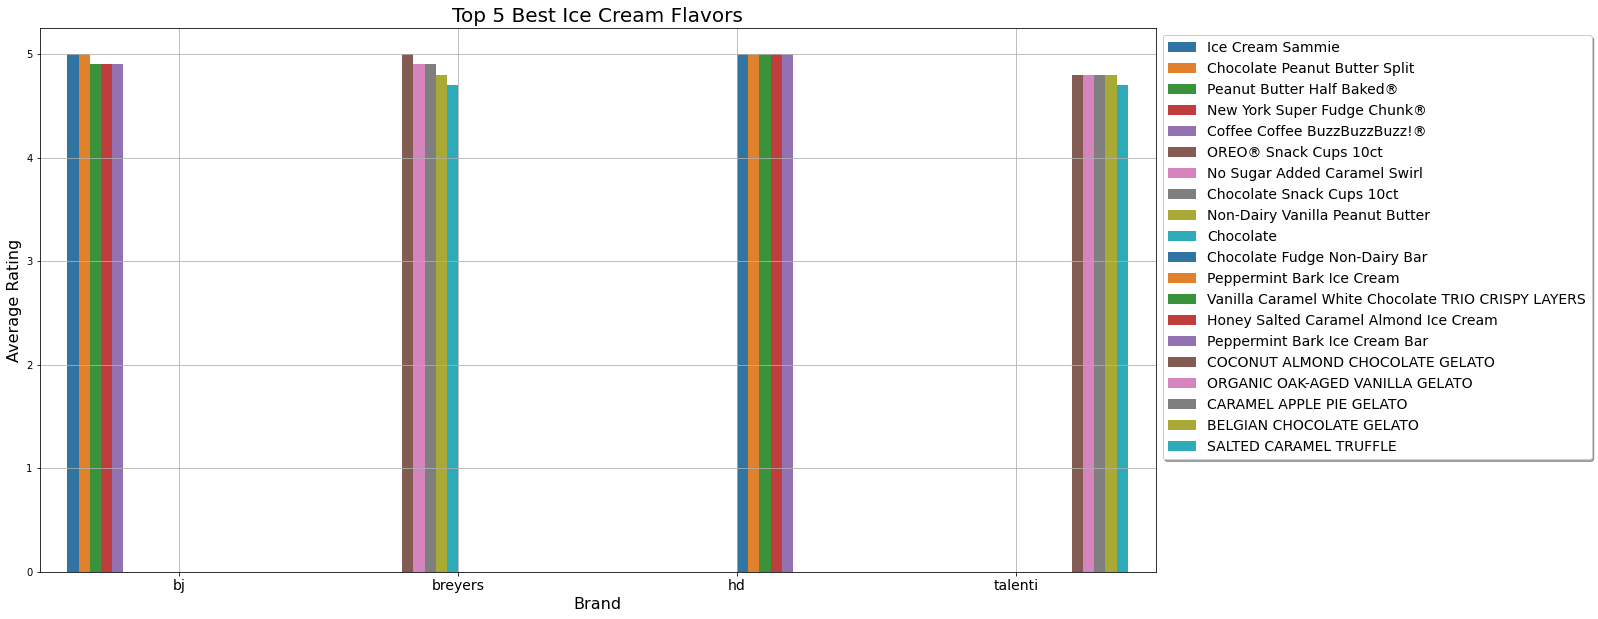

In [22]:
plt.figure(figsize=(20,10))
ax = sns.barplot(x="brand", y="rating", hue="flavor", data=top5_df,  palette=sns.color_palette("tab10"))
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=1, fancybox=True, shadow=True, fontsize=14)
plt.title('Top 5 Best Ice Cream Flavors', fontsize=20)
plt.xlabel("Brand", fontsize=16)
plt.ylabel("Average Rating", fontsize=16)
plt.xticks(label=["Haagend Daaz", "Talenti", "Breyers", "Ben and Jerry's"], fontsize=14)
plt.grid()
plt.show()

Interesting to see that the best Breyers' flavors all seem to be some sort of low calorie/vegan/lactose-free option.

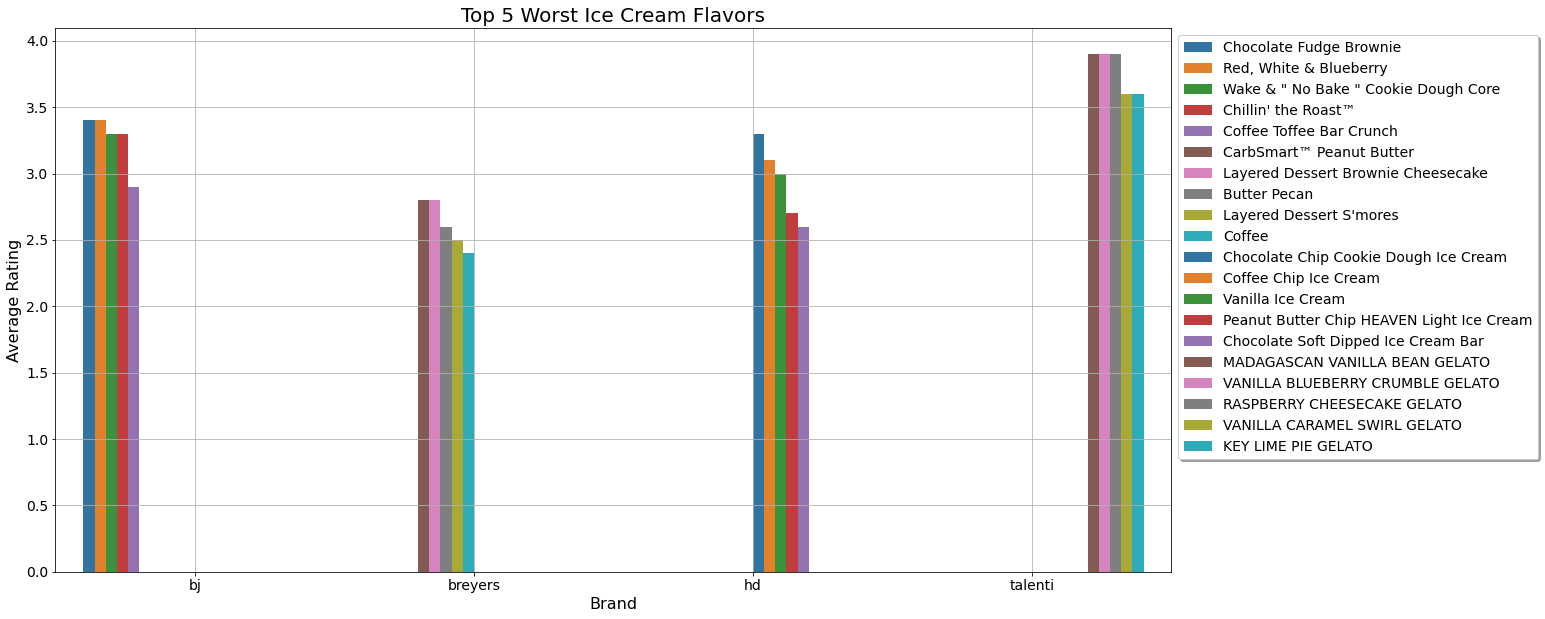

In [23]:
plt.figure(figsize=(20,10))
ax = sns.barplot(x="brand", y="rating", hue="flavor", data=bottom5_df, palette=sns.color_palette("tab10"))
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=1, fancybox=True, shadow=True, fontsize=14)
plt.title('Top 5 Worst Ice Cream Flavors', fontsize=20)
plt.xlabel("Brand", fontsize=16)
plt.ylabel("Average Rating", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.show()

I personally love cookie dough flavored ice cream, so I am surprised to even see a few cookie dough flavors amongst the lowest ranked. I also notice that these lower ranked flavors are a bit more *complex* than the higher ranked -- many contain cake, cookiedough, cheesecake, pie, smore's or brownie in the flavor name.
One last note is that Breyers' tend to have lower rankings and talenti among the higher.

## Analyzing Stars and Ratings

In each review, the user can provide rating on a scale of 1 to 5 stars. First, I am intersted in seeing the average number of stars by brand.

In [24]:
avg_stars_by_brand = [data[data['brand'] == brand]['stars'].mean() for brand in brands]

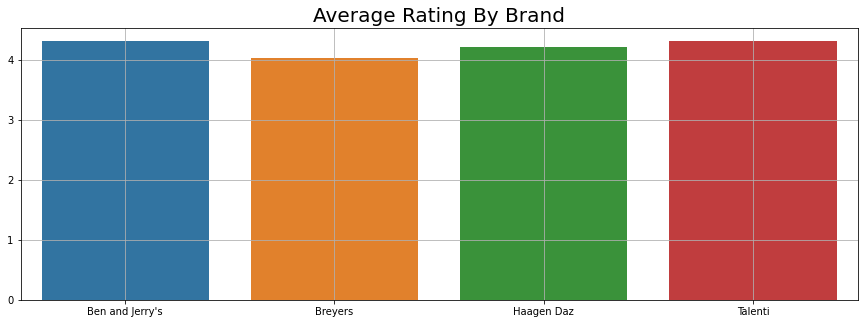

In [25]:
plt.figure(figsize=(15, 5))
sns.barplot(x=brand_labels, y=avg_stars_by_brand)
plt.title('Average Rating By Brand', fontsize=20)
plt.grid()
plt.show()

Seems that Breyers' tends to have a bit of a lower rating. Ben and Jerry's and Talenti seem to be rated quite highly.

The distribution of the ratings may shed some more light on these brands.

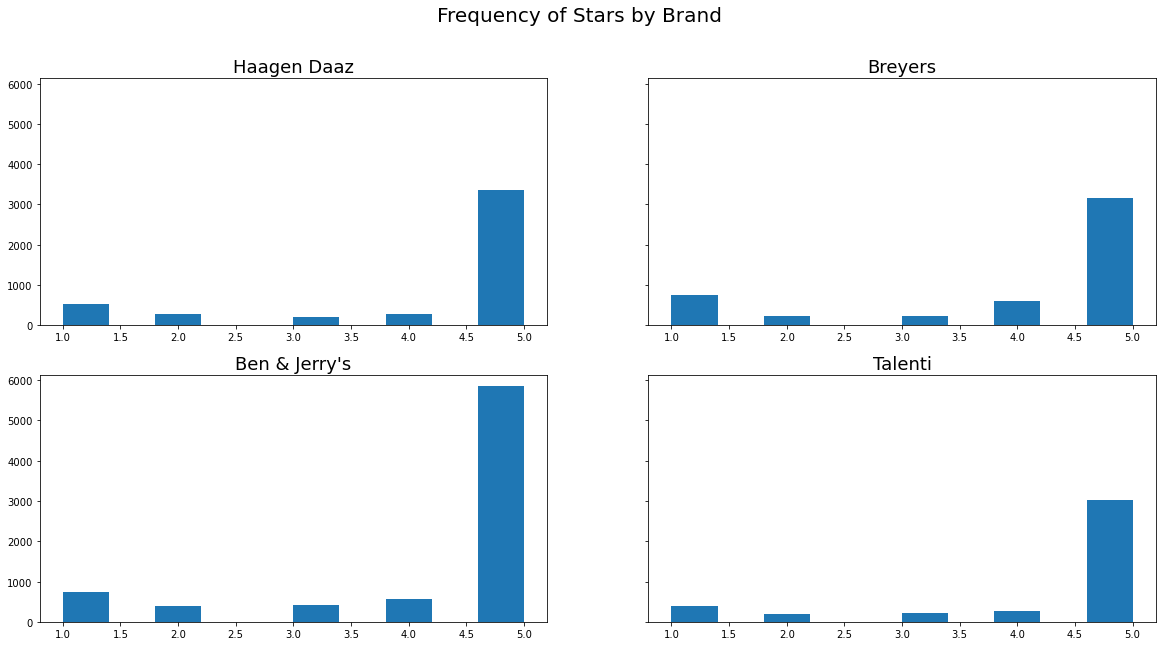

In [26]:
fig, axes = plt.subplots(2, 2, figsize=(20,10), sharey=True)
fig.suptitle('Frequency of Stars by Brand', fontsize=20)
axes[0, 0].hist(data[data['brand']=='hd']['stars'])
axes[0, 0].set_title('Haagen Daaz', fontsize=18)
axes[0, 1].hist(data[data['brand']=='breyers']['stars'])
axes[0, 1].set_title('Breyers', fontsize=18)
axes[1, 0].hist(data[data['brand']=='bj']['stars'])
axes[1, 0].set_title('Ben & Jerry\'s', fontsize=18)
axes[1, 1].hist(data[data['brand']=='talenti']['stars'])
axes[1, 1].set_title('Talenti', fontsize=18)
plt.rcParams['axes.grid'] = True
plt.show()

Distributions acorss each brand are pretty similar. It is obvious, though that Ben & Jerry's has a much higher number number of 5 star ratings than any other brand. This is likely because Ben & Jerry's has the largest share of reviews.

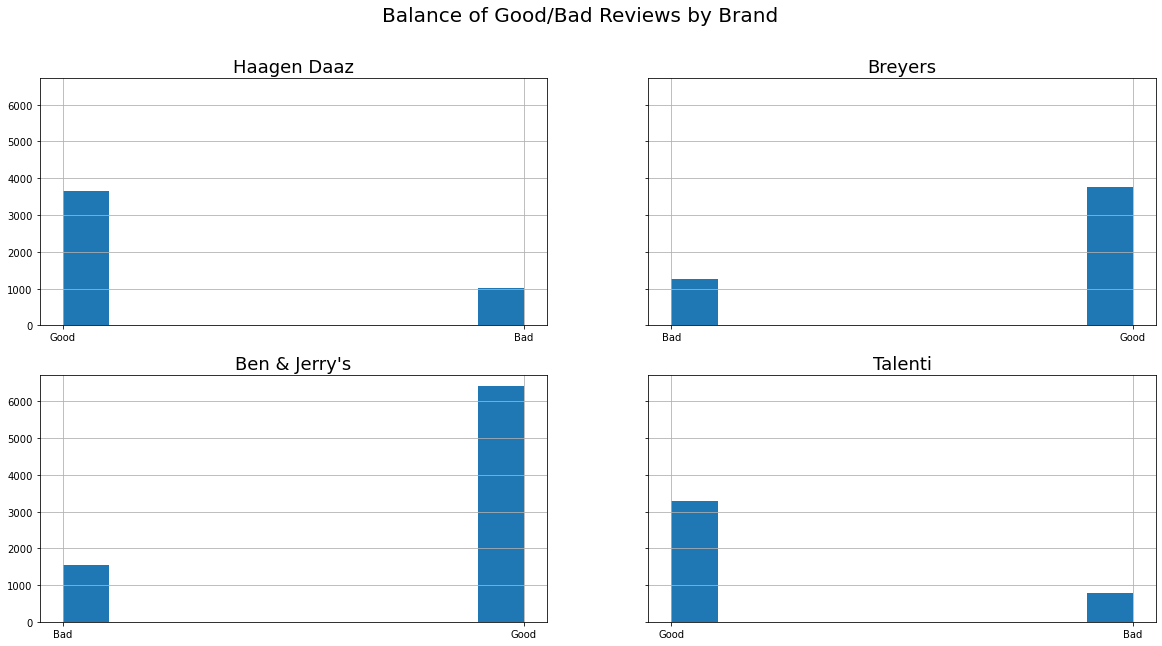

In [27]:
fig, axes = plt.subplots(2, 2, figsize=(20,10), sharey=True)
fig.suptitle('Balance of Good/Bad Reviews by Brand', fontsize=20)
axes[0, 0].hist(data[data['brand']=='hd']['good_review'])
axes[0, 0].set_title('Haagen Daaz', fontsize=18)
axes[0, 1].hist(data[data['brand']=='breyers']['good_review'])
axes[0, 1].set_title('Breyers', fontsize=18)
axes[1, 0].hist(data[data['brand']=='bj']['good_review'])
axes[1, 0].set_title('Ben & Jerry\'s', fontsize=18)
axes[1, 1].hist(data[data['brand']=='talenti']['good_review'])
axes[1, 1].set_title('Talenti', fontsize=18)
plt.rcParams['axes.grid'] = True
plt.show()

Distributions of the ratings are pretty similar. Ben & Jerry's, however, clearly has a higher number of 4 & 5 star ratings.

In [28]:
brands_5_star_percent = np.array(data[data['stars']==5]['brand'].value_counts())/sum(data[data['stars']==5]['brand'].value_counts())
brands_4_star_percent = np.array(data[data['stars']==4]['brand'].value_counts())/sum(data[data['stars']==4]['brand'].value_counts())
brands_3_star_percent = np.array(data[data['stars']==3]['brand'].value_counts())/sum(data[data['stars']==3]['brand'].value_counts())
brands_2_star_percent = np.array(data[data['stars']==2]['brand'].value_counts())/sum(data[data['stars']==2]['brand'].value_counts())
brands_1_star_percent = np.array(data[data['stars']==1]['brand'].value_counts())/sum(data[data['stars']==1]['brand'].value_counts())
brands_good_percent = np.array(data[data['good_review']=="Good"]['brand'].value_counts())/sum(data[data['good_review']=="Good"]['brand'].value_counts())
brands_bad_percent = np.array(data[data['good_review']=='Bad']['brand'].value_counts())/sum(data[data['good_review']=="Bad"]['brand'].value_counts())


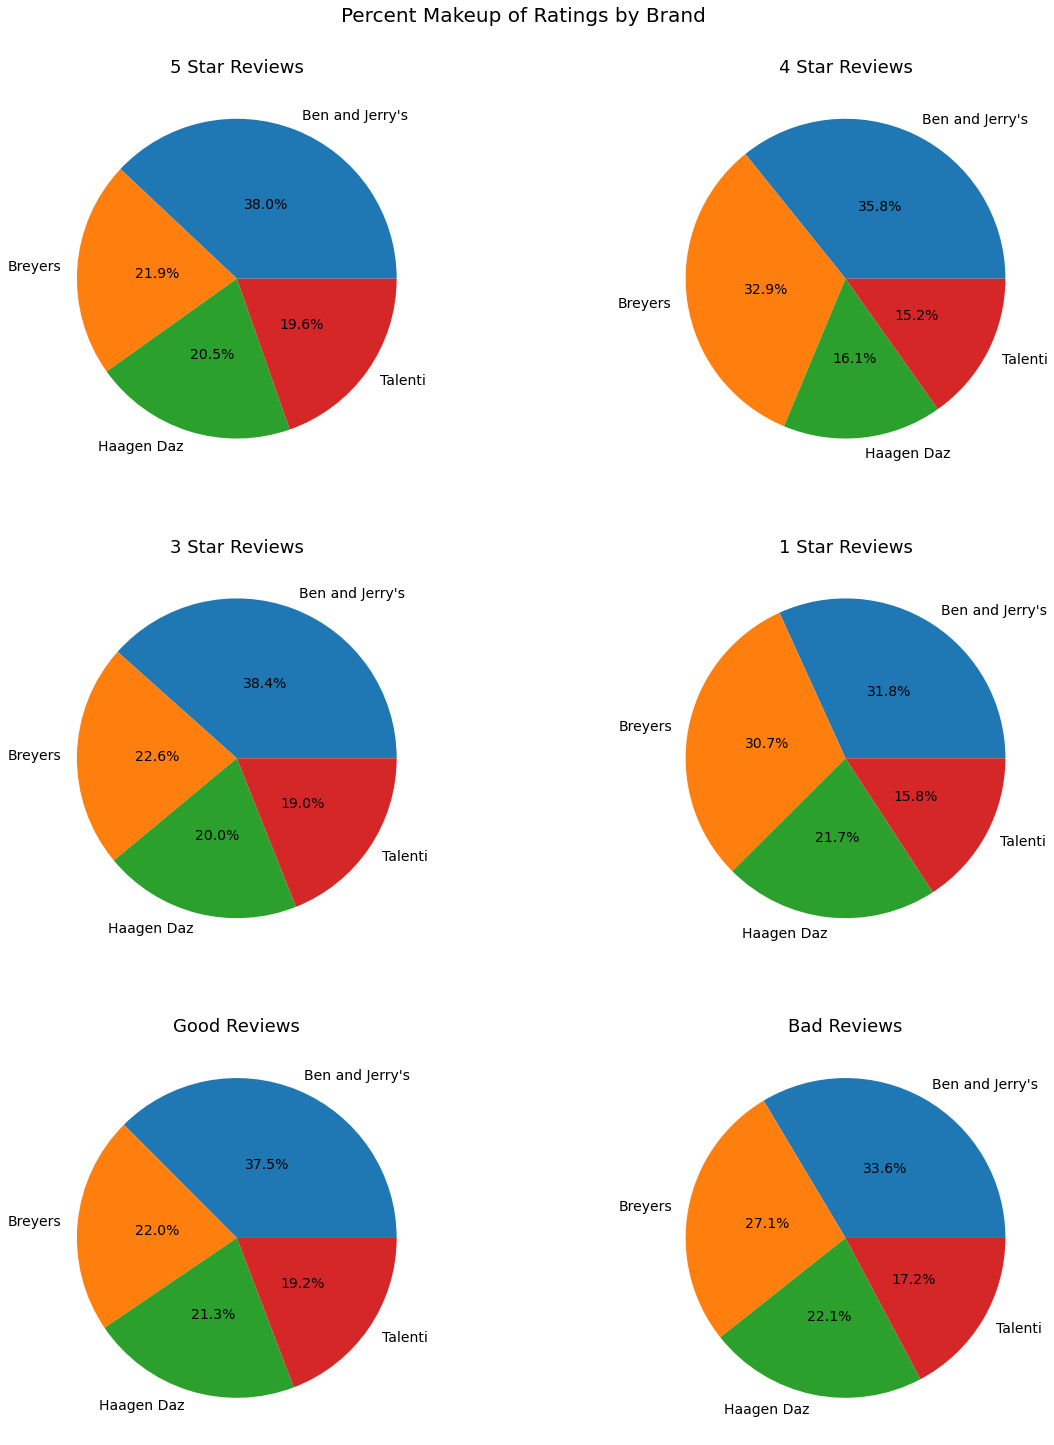

In [42]:
fig, axes = plt.subplots(3,2, figsize=(20,25))
fig.suptitle('Percent Makeup of Ratings by Brand', fontsize=20, y=0.92)
axes[0,0].pie(x=brands_5_star_percent, autopct="%.1f%%", labels=brand_labels, pctdistance=0.5, textprops={'fontsize': 14})
axes[0, 0].set_title('5 Star Reviews', fontsize=18)
axes[0,1].pie(x=brands_4_star_percent, autopct="%.1f%%", labels=brand_labels, pctdistance=0.5, textprops={'fontsize': 14})
axes[0, 1].set_title('4 Star Reviews', fontsize=18)
axes[1,0].pie(x=brands_3_star_percent, autopct="%.1f%%", labels=brand_labels, pctdistance=0.5, textprops={'fontsize': 14})
axes[1, 0].set_title('3 Star Reviews', fontsize=18)
axes[1,1].pie(x=brands_1_star_percent, autopct="%.1f%%", labels=brand_labels, pctdistance=0.5, textprops={'fontsize': 14})
axes[1, 1].set_title('1 Star Reviews', fontsize=18)
axes[2,0].pie(x=brands_good_percent, autopct="%.1f%%", labels=brand_labels, pctdistance=0.5, textprops={'fontsize': 14})
axes[2, 0].set_title('Good Reviews', fontsize=18)
axes[2,1].pie(x=brands_bad_percent, autopct="%.1f%%", labels=brand_labels, pctdistance=0.5, textprops={'fontsize': 14})
axes[2, 1].set_title('Bad Reviews', fontsize=18)
plt.show()

Nothing too extreme here. All the reviews by brand are pretty balanced. There is a slight pattern that the proportion of reviews for Breyers and Haagen Daz increases when we look at the good then bad reviews. Overall, this is a sign that `brand` is not a good indicator for predicting the number of stars a review gets.

# Sentiment Analysis

Next, I'll perform a sentiment analysis on the text data. Using the polarity and subjectivity, I'll be able to generalize what customers really think of the ice cream that they have purchased.

I'll start by defining some of functions to get the subjectivity and polarity of each review.

In [43]:
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

In [44]:
def getPolarity(text):
    return TextBlob(text).sentiment.polarity

I'll apply these functions and plot out the entire polarity and senitment in a nice scatter plot.

In [47]:
data['subjectivity'] = data['text'].apply(getSubjectivity)
data['polarity'] = data['text'].apply(getPolarity)

In [48]:
data.head(10)

,author,brand,name,rating,rating_count,stars,text,good_review,subjectivity,polarity
0,Ilovebennjerry,bj,Salted Caramel Core,3.7,208,3,not enough brownie super good dont get wrong b...,Bad,0.621989,0.145276
1,Sweettooth909,bj,Salted Caramel Core,3.7,208,5,im obsessed pint i decided try although im hug...,Good,0.328638,0.065873
2,LaTanga71,bj,Salted Caramel Core,3.7,208,3,my favoritemore caramel please my caramel core...,Bad,0.301515,0.075379
3,chicago220,bj,Salted Caramel Core,3.7,208,5,obsessed why people complaining blonde brownie...,Good,0.546154,0.085577
4,Kassidyk,bj,Salted Caramel Core,3.7,208,1,worst ice cream ever this ice cream worst ice ...,Bad,0.579524,-0.137222
5,Nikiera,bj,Salted Caramel Core,3.7,208,2,way too salty i bought last night go louisiana...,Bad,0.552381,0.000000
6,Mmelvin,bj,Salted Caramel Core,3.7,208,3,love flavor this definitely favorite flavor re...,Bad,0.506746,-0.019246
7,Shay10,bj,Salted Caramel Core,3.7,208,3,really wanted to love this i chocolate person ...,Bad,0.464352,0.282639
8,caramel4dayz,bj,Salted Caramel Core,3.7,208,2,could better i love caramel much i could eat s...,Bad,0.496429,0.232143
9,RosaT777,bj,Salted Caramel Core,3.7,208,3,salted caramel core no caramel i love ben jerr...,Bad,0.783333,0.083333


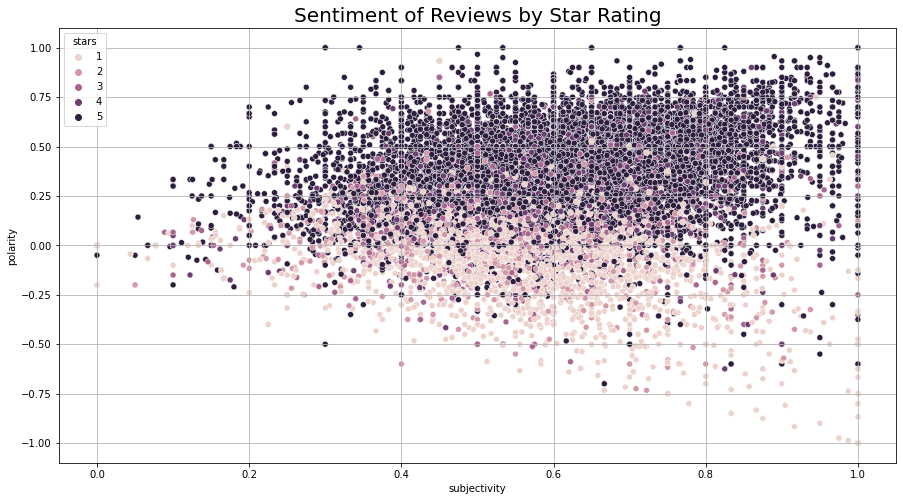

In [49]:
plt.figure(figsize=(15, 8))
sns.scatterplot(x='subjectivity', y='polarity', data=data, hue='stars')
plt.title('Sentiment of Reviews by Star Rating', fontsize=20)
plt.show()

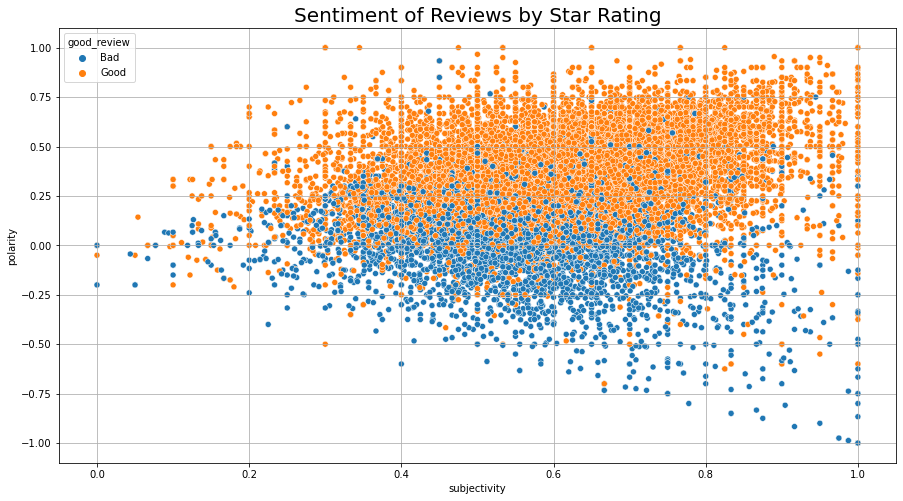

In [50]:
plt.figure(figsize=(15, 8))
sns.scatterplot(x='subjectivity', y='polarity', data=data, hue='good_review')
plt.title('Sentiment of Reviews by Star Rating', fontsize=20)
plt.show()

There is a clear pattern here. The higher star reviews tend toward the higher polarity and the lower stars tend to have a lower polarity.

I am also interested to check the polarity and sentiment of the top 5 and bottom 5 worst flavors from each brand, and see if they truly line up with rating plot from before.

In [51]:
top_and_bottom_5_flavors = top5_df.append(bottom5_df)['flavor']

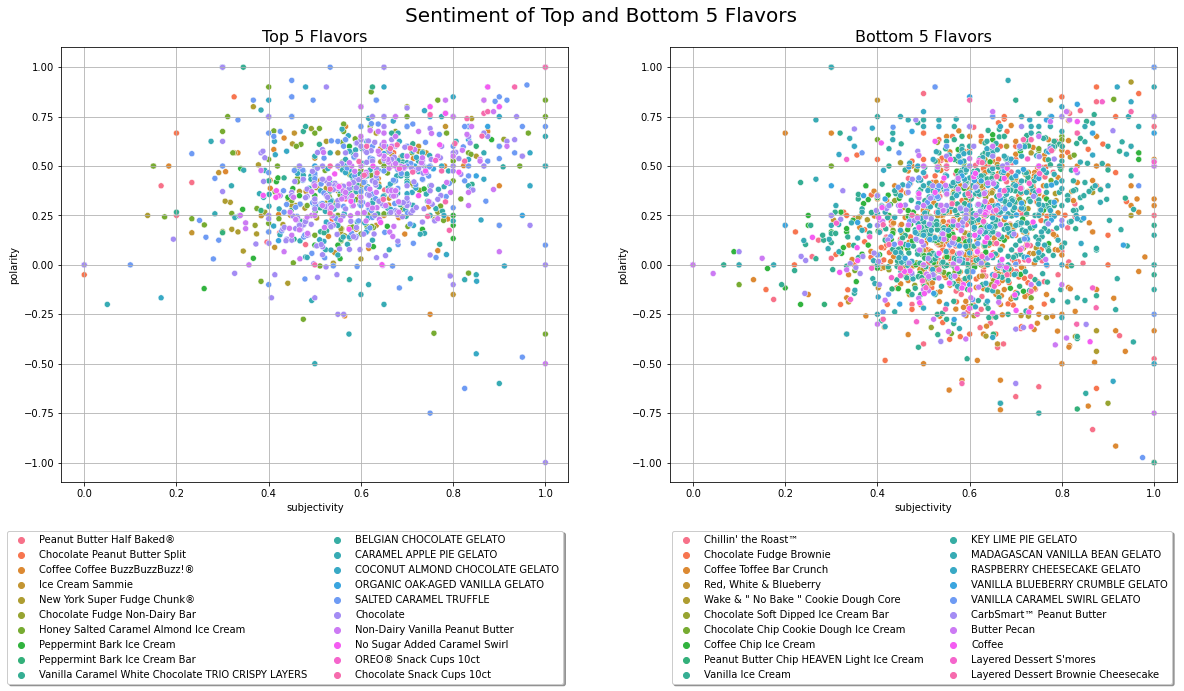

In [52]:
fig, axes = plt.subplots(1,2, figsize=(20,8))
fig.suptitle('Sentiment of Top and Bottom 5 Flavors', fontsize=20, y=0.95)
scatter1 = sns.scatterplot(x='subjectivity', y='polarity', data=data[data['name'].isin(top5_df['flavor'])], hue='name', ax=axes[0])
scatter1.legend(loc='best', bbox_to_anchor=(1, -0.1), ncol=2, fancybox=True, shadow=True)
axes[0].set_title('Top 5 Flavors', fontsize=16)
scatter2 = sns.scatterplot(x='subjectivity', y='polarity', data=data[data['name'].isin(bottom5_df['flavor'])], hue='name', ax=axes[1])
scatter2.legend(loc='best', bbox_to_anchor=(1, -0.1), ncol=2, fancybox=True, shadow=True)
axes[1].set_title('Bottom 5 Flavors', fontsize=16)
plt.show()

Clear differences between the sentiment of the top and bottom 5 flavors from each brand. As suspected, the polarity of the bottom 5 flavors tends more negative than the top 5 flavors.

## Word Cloud

Lastly, I'll create some word clouds to see what words stand out amongst the good and bad reviews.

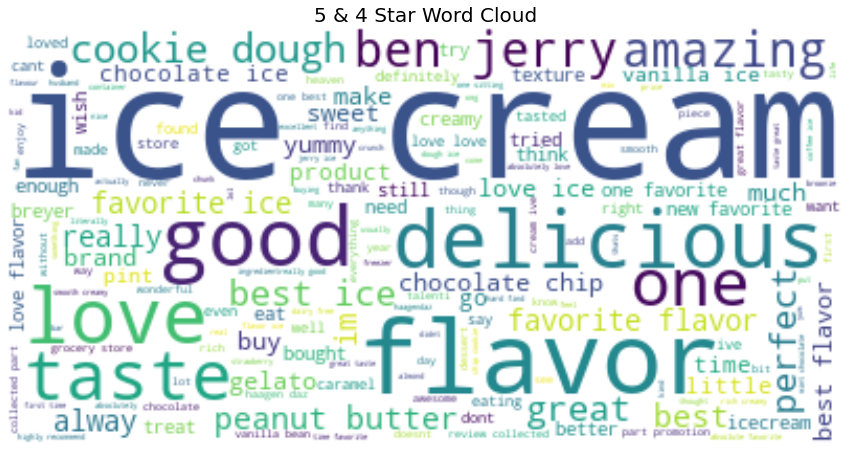

In [68]:
all_words_good = " ".join([review for review in data[data['good_review']=='Good']['text']])
word_cloud_good = WordCloud(background_color="white", random_state=1, max_font_size=100).generate(all_words_good)
plt.figure(figsize=(15, 20))
plt.imshow(word_cloud_good, interpolation='bilinear')
plt.axis('off')
plt.title("5 & 4 Star Word Cloud", fontsize=20)
plt.show()

From the 5, 4 star word cloud, I notice a few things:
* Ben & Jerry, Taltenti and Haagen Daz appear
* Several postive words such as grteat, amazing, perfectm favorite
* No negative words

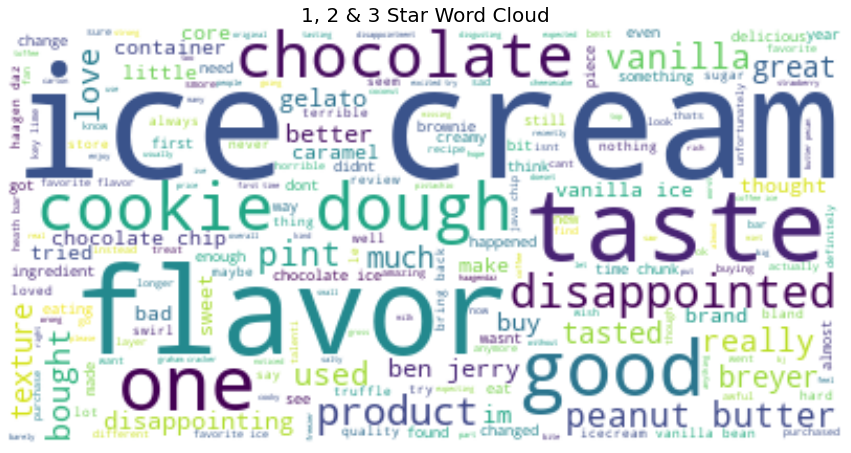

In [67]:
all_words_bad = " ".join([review for review in data[data['good_review']=='Bad']['text']])
word_cloud_bad = WordCloud(background_color="white", random_state=1, max_font_size=100).generate(all_words_bad)
plt.figure(figsize=(15, 20))
plt.imshow(word_cloud_bad, interpolation='bilinear')
plt.axis('off')
plt.title("1, 2 & 3 Star Word Cloud", fontsize=20)
plt.show()

From the 1, 2, 3 star word cloud, I notice a few things:
* Breyers and Haagen Daz appear
* Several postive words such as love, favorite and delicous
* Several negative words such as dissapointed, terrible, horrible and wrong